# Using LLMs as High-Level Planners for Multi-Agent Coordination

This notebook provides a step-by-step guide to customizing and interacting with the RL environment.

## For Submission
1. Fill in your code in `submit.py`. 
   - Add your code *only* in the TODO sections marked by the '#' delimiter lines. Do not modify any other parts of the script.
   - You should implement any helper functions/classes in a separate `helper.py` file and import them in `submit.py`.
1. Submit `out.log` and `results.csv` generated by the `submit.py` script.


In [51]:
# Import necessary libraries and modules
import gymnasium as gym
import multigrid.envs
import matplotlib.pyplot as plt
from agents import AgentCollection
from IPython.display import clear_output

%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


---
## Initial Plan Generation

An intial plan can be generated by the `initial_planner` by invoking it with the grid size and number of agents available.

In [52]:
import configparser

config = configparser.ConfigParser()
config.read("env_config.ini")

environments = {}
for section in config.sections():
    M = config.getint(section, "number_of_agents")
    N = config.getint(section, "grid_size")
    goals = eval(config.get(section, "goals"))
    mission_statement = eval(config.get(section, "mission_statement"))
    # num_trials = config.getint(section, "number_of_trials")
    environments[section] = {
        "N": N,
        "M": M,
        "goals": goals,
        "mission_statement": mission_statement,
    }

In [53]:
from models import local_llm as llm
from planner import SuperPlanner as Planner

In [60]:
selected_env = environments["env.AGENT_5_2"]
env = multigrid.envs.EmptyEnvV2(
    size=selected_env["N"],  # Specify the size of the grid, N
    agents=selected_env["M"],  # Specify number of agents, M
    goals=selected_env["goals"],  # Specify target positions for agents
    mission_space=selected_env["mission_statement"],
    render_mode="rgb_array",
    hidden_goals=True,
    # max_steps=50, # For debugging, you can set a maximum number of steps
)

# Always reset the environment before starting
observations, infos = env.reset()

agents = AgentCollection(num=selected_env["M"])

planner = Planner(
    llm=llm, grid_size=selected_env["N"], observations=observations, infos=infos
)

# Providing the agents with high-level instructions
mission = observations[0]["mission"]
text_plan, plan = planner.initial_plan()
for agent, actions in plan.items():
    for action in actions:
        agents.tell({agent: action.serialize()})

> We are on a 60×60 grid with 3 agents starting at (1,1). The mission indicates two target-rich regions:  
> - A dense cluster from (6,6) to (12,12), containing 2 targets.  
> - Another dense cluster from (48,48) to (54,54), also containing 2 targets.  
>   
> Given that the total number of targets is only 4 and 90%+ of them are expected within these two regions, our primary focus must be on **exhaustively searching both high-probability zones** while ensuring **no agent remains idle** and **all areas are covered** to maximize the chance of earning the massive full-discovery bonus.  
>   
> Agent 0 will move from (1,1) to (6,6), then perform a snake-like search of the region from (6,6) to (12,12). This region is compact (7×7 = 49 cells), contains half the targets, and is relatively close to the start point.  
>   
> Agent 1 will move from (1,1) to (48,48), then search the region from (48,48) to (54,54). This region is farther but equally important — it contains the other 2 targets. Mov

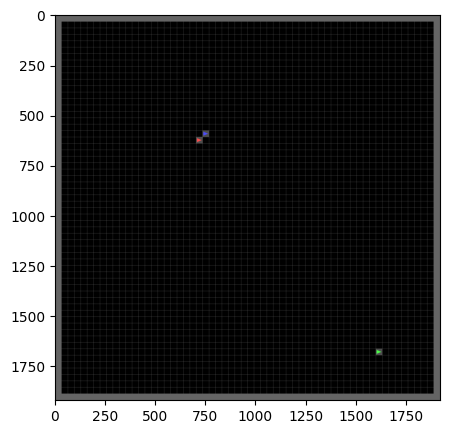


{0: {'image': array([[[1, 0, 0]]]), 'direction': np.int64(0), 'mission': Mission("Two targets are in the region from (6, 6) to (12, 12), and two targets are in the region from (48, 48) to (54, 54)."), 'location': (np.int64(22), np.int64(19))}, 1: {'image': array([[[1, 0, 0]]]), 'direction': np.int64(0), 'mission': Mission("Two targets are in the region from (6, 6) to (12, 12), and two targets are in the region from (48, 48) to (54, 54)."), 'location': (np.int64(50), np.int64(52))}, 2: {'image': array([[[1, 0, 0]]]), 'direction': np.int64(0), 'mission': Mission("Two targets are in the region from (6, 6) to (12, 12), and two targets are in the region from (48, 48) to (54, 54)."), 'location': (np.int64(23), np.int64(18))}, 'global': {'num_goals': 0}}
{0: <ActionUpDown.right: 1>, 1: <ActionUpDown.right: 1>, 2: <ActionUpDown.right: 1>} {0: -1, 1: 1, 2: -1} {0: np.True_, 1: np.True_, 2: np.True_} {0: False, 1: False, 2: False} defaultdict(<class 'dict'>, {'cur_reward': np.float64(198.812499

In [61]:
while not env.unwrapped.is_done():
    # Obtain the low-level action for current time step for all agents
    a = agents.act()

    # Step the environment with the actions
    observations, rewards, terminations, truncations, infos = env.step(a)

    # Render the environment
    clear_output(wait=True)
    img = env.render()
    plt.figure(figsize=(5, 5))
    plt.imshow(img)
    plt.show()
    print(text_plan)
    print(observations)
    print(a, rewards, terminations, truncations, infos)
    print(infos["total_reward"])

    if env.unwrapped.is_done():
        break

    text_plan, plan = planner.replan(
        agents, observations, rewards, terminations, truncations, infos
    )
    text_plans.append(text_plan)
    for agent, actions in plan.items():
        for action in actions:
            agents.tell({agent: action.serialize()})

print(infos["total_reward"])
env.close()